In [1]:
import pickle
import gurobipy as gp
import matplotlib.pyplot as plt
from gurobipy import GRB
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
from itertools import product
import psutil  # to monitor memory
%load_ext autoreload
%autoreload 2
%aimport Master
%aimport Separation
%aimport Methods
%aimport Data

In [30]:
sep_env = gp.Env()
sep_env.setParam('Method', 0)
sep_env.setParam('OutputFlag', 0)
sep_env.setParam('NumericFocus', 2)
sep_env.setParam('DualReductions', 0)
master_env = gp.Env()
master_env.setParam('OutputFlag', 1)
master_env.setParam('TimeLimit', 800)
master_env.setParam('MIPGap', 0.005)

Set parameter Username
Set parameter LicenseID to value 2625858
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter Method to value 0
Set parameter Username
Set parameter LicenseID to value 2625858
Academic license - for non-commercial use only - expires 2026-02-20
Set parameter TimeLimit to value 800
Set parameter MIPGap to value 0.005


In [92]:
from Data import ModelsData
mg_id = 1
data = ModelsData(mg_id=mg_id)
x_keys = data.x_keys

In [93]:
from Separation import Separation
separations = []
for scenario_index in tqdm(range(len(data.Pr))):
    separations.append(Separation(data=data, scenario_index=scenario_index, env=sep_env))
mem = psutil.virtual_memory()
print(f"Used: {mem.percent}% | Available: {mem.available / 1e9:.2f} GB")

100%|██████████| 27/27 [30:05<00:00, 66.89s/it]

Used: 80.1% | Available: 3.37 GB


### Functions

In [94]:
from Methods import get_T_r
def get_T_r_all(separations, x_keys):
    return zip(*[get_T_r(sep, x_keys) for sep in separations])

In [95]:
def get_solutions(master, separations, data, probs, param):
    # Get values and save in dict
    capital_I = master.capital_cost.getValue()
    capital_E = np.average(
        [sep.capital_cost_E.x for sep in separations], weights=probs)
    bill_saving = np.average(
        [get_bill_saving(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)], weights=probs)

    Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)])
    Phi = np.average(Phi, weights=probs)
    Lambda = np.average(Lambda, weights=probs)
    E = np.average(E, weights=probs)

    new_row = [param, capital_I, capital_E, bill_saving, Phi, Lambda, E]
    return new_row

In [96]:
def get_X(master, separations, optimal_x, data, probs):
    optimal_x_e = []
    for f in separations:
        vars = f.model.getVars()[:len(optimal_x)]
        f.model.setAttr('LB', vars, optimal_x)
        f.model.setAttr('UB', vars, optimal_x)
        f.model.optimize()
        optimal_x_e.append(f.X_E.x)
    optimal_x_e = np.average(optimal_x_e, axis=0, weights=probs)
    optimal_x_i = optimal_x[:data.L * data.D].reshape((data.L, data.D))
    X = optimal_x_i + optimal_x_e
    X = X.sum(axis=0)
    return X

### Sensitivity PV

In [104]:
pv = [0.8, 1.2]
pv_sensitivity = {
    'pv': pv,
    **({item: np.zeros_like(pv, float)
        for item in ['Investment', 'Expansion', 'Bill Saving', 'Phi', 'Lambda', 'E', 'ES', 'PV', 'DG']})}
pv_sensitivity = pd.DataFrame(pv_sensitivity)

In [109]:
from Separation import Separation
from Master import Master
from Methods import *

probs = data.Pr
for row, pv_coeff in enumerate(pv):
    if row == 0:
        for sep in separations:
            for i, g, t, in np.ndindex((data.I, data.G, data.T)):
                coef = np.clip(pv_coeff * data.PV[g, t], 1e-4, 1)
                constr = sep.model.getConstrByName(f'pv_usage[{i},{g},{t}]')
                sep.model.chgCoeff(constr, sep.PV[i], coef)
            sep.model.update()
        # Get T and r of all
        T, r = get_T_r_all(separations, data_temp)
        T, r = list(T), list(r)

        # Build master
        master = Master(data_temp, master_env, scale=1)

        # Solve calling BB-BandB
        optimal_x, optimal_obj = solve_with_BD_BandB(master=master, seps=separations, probs=probs,
                                                     TMatrices=T, rVectors=r, data=data_temp)
        # Get values and save in dict
        capital_I = master.X_I.X.sum(axis=0) @ data_temp.C
        capital_E = np.average(
            [sep.capital_cost_E.x for sep in separations], weights=probs)
        bill_saving = np.average(
            [get_bill_saving(sep, scenario, data_temp, data.e_load, data.e_drp) for scenario, sep in zip(data.Sc, separations)], weights=probs)
        X = get_X(master, separations, optimal_x, data_temp, probs)

        Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data_temp) for scenario, sep in zip(data.Sc, separations)])
        Phi = np.average(Phi, weights=probs)
        Lambda = np.average(Lambda, weights=probs)
        E = np.average(E, weights=probs)

        new_row = [pv_coeff, capital_I, capital_E, bill_saving, Phi, Lambda, E, X[0], X[1], X[2]]
        pv_sensitivity.iloc[row] = new_row
pv_sensitivity.to_csv(f'Results/(MG{mg_id})sensitivity_pv.csv', index=False)

Set parameter LazyConstraints to value 1
Set parameter NumericFocus to value 3
Set parameter LogFile to value "Models/master_log.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 21 columns and 85 nonzeros
Model fingerprint: 0x585807da
Variable types: 1 continuous, 20 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+10]
  RHS range        [2e+01, 1e+06]
Presolve time: 0.00s
Presolved: 20 rows, 21 columns, 85 nonzeros
Variable types: 1 continuous, 20 integer (5 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+10   0.000000e+00   0.000000e+00     10s

Root relaxation: objective -1.000000e+10, 0 iterations, 0.01 seconds (0.00 wo

#### Sensitivity DRP

In [38]:
drp = [0, 0.2, 0.4, 0.6, 0.8, 1.00]
drp_sensitivity = {
    'drp': drp,
    **({item: np.zeros_like(drp, float)
        for item in ['Investment', 'Expansion', 'Bill Saving', 'Phi', 'Lambda', 'E']})}
drp_sensitivity = pd.DataFrame(drp_sensitivity)

In [39]:
for sep in separations:
    for i, g, t in np.ndindex(data.I, data.G, data.T):
        coeff = data.PV[g, t]
        constr = sep.model.getConstrByName(f'pv_usage[{i},{g},{t}]')
        sep.model.chgCoeff(constr, sep.PV[i], coeff)
    sep.model.update()

In [40]:
from Separation import Separation
from Master import Master
from Methods import *

probs = data.Pr
for row, drp_rate in enumerate(drp):
    e_drp = data.e_grid_import * (1 + drp_rate)
    # Change param in the model
    for sep in separations:
        for i, g, t in np.ndindex(data.I, data.G, data.T):
            constr = sep.model.getConstrByName(f'max_trans_load[{i},{g},{t}]')
            sep.model.chgCoeff(constr, sep.Load[i, g, t], drp_rate)
        for i in data.i_index:
            sep.model.remove(sep.model.getConstrByName(f'C_In{i}'))
            sum_DRP = sep.Y_LT[i].sum()
            sep.model.addConstr(sep.C_IN[i] == e_drp * sum_DRP, name=f'C_In{i}')
        sep.model.update()


    # Get T and r of all
    T, r = get_T_r_all(separations, data)
    T, r = list(T), list(r)

    # Build master
    master = Master(data, master_env, 1)

    # Solve calling BB-BandB
    optimal_x, optimal_obj = solve_with_BD_BandB(master=master, seps=separations, probs=probs,
                                                 TMatrices=T, rVectors=r, data=data)
    # Get values and save in dict
    capital_I = master.X_I.X.sum(axis=0) @ data.C
    capital_E = np.average(
        [sep.capital_cost_E.x for sep in separations], weights=probs)
    bill_saving = np.average(
        [get_bill_saving(sep, scenario, data, data.e_load, e_drp) for scenario, sep in zip(data.Sc, separations)], weights=probs)

    Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)])
    Phi = np.average(Phi, weights=probs)
    Lambda = np.average(Lambda, weights=probs)
    E = np.average(E, weights=probs)

    new_row = [drp_rate, capital_I, capital_E, bill_saving, Phi, Lambda, E]
    drp_sensitivity.iloc[row] = new_row
drp_sensitivity.to_csv(f'Results/(MG{mg_id})sensitivity_drp.csv', index=False)

Set parameter LazyConstraints to value 1
Set parameter NumericFocus to value 3
Set parameter LogFile to value "Models/master_log.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 13 columns and 51 nonzeros
Model fingerprint: 0x4b624cef
Variable types: 1 continuous, 12 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+10]
  RHS range        [3e+01, 1e+06]
Presolve time: 0.00s
Presolved: 14 rows, 13 columns, 51 nonzeros
Variable types: 1 continuous, 12 integer (3 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+10   0.000000e+00   0.000000e+00      8s

Root relaxation: objective -1.000000e+10, 0 iterations, 0.00 seconds (0.00 wo

### Sensitivity power price

In [41]:
price = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
price_sensitivity = {
    'price': price,
    **({item: np.zeros_like(price, float)
        for item in ['Investment', 'Expansion', 'Bill Saving', 'Phi', 'Lambda', 'E']})}
price_sensitivity = pd.DataFrame(price_sensitivity)

In [42]:
# Reset if needed
e_drp = data.e_grid_import * (1 + 0.2)
for sep in separations:
    for i, g, t in np.ndindex(data.I, data.G, data.T):
        constr = sep.model.getConstrByName(f'max_trans_load[{i},{g},{t}]')
        sep.model.chgCoeff(constr, sep.Load[i, g, t], 0.2)

    sep.model.remove(sep.model.getConstrByName(f'C_In{i}'))
    sum_DRP = sep.Y_LT[i].sum()
    sep.model.addConstr(sep.C_IN[i] == e_drp * sum_DRP, name=f'C_In{i}')
    sep.model.update()

In [43]:
from Separation import Separation
from Master import Master
from Methods import *

probs = data.Pr
for row, rate in enumerate(price):
    e_load = rate * data.e_grid_import
    # Change param in the model
    for sep in separations:
        for i in data.i_index:
            sep.model.remove(sep.model.getConstrByName(f'C_R{i}'))
            sum_Load = sep.Y_ESL[i].sum() + sep.Y_PVL[i].sum() + sep.Y_DGL[i].sum()
            sep.model.addConstr(sep.C_R[i] == e_load * sum_Load, name=f'C_R{i}')
            sep.model.update()

    # Get T and r of all
    T, r = get_T_r_all(separations, data)
    T, r = list(T), list(r)

    # Build master
    master = Master(data, master_env, 1)

    # Solve calling BB-BandB
    optimal_x, optimal_obj = solve_with_BD_BandB(master=master, seps=separations, probs=probs,
                                                 TMatrices=T, rVectors=r, data=data)

    # Get values and save in dict
    capital_I = master.X_I.X.sum(axis=0) @ data.C
    capital_E = np.average(
        [sep.capital_cost_E.x for sep in separations], weights=probs)
    bill_saving = np.average(
        [get_bill_saving(sep, scenario, data, e_load, e_drp) for scenario, sep in zip(data.Sc, separations)], weights=probs)

    Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)])
    Phi = np.average(Phi, weights=probs)
    Lambda = np.average(Lambda, weights=probs)
    E = np.average(E, weights=probs)

    new_row = [rate, capital_I, capital_E, bill_saving, Phi, Lambda, E]
    price_sensitivity.iloc[row] = new_row
price_sensitivity.to_csv(f'Results/(MG{mg_id})sensitivity_price.csv', index=False)

Set parameter LazyConstraints to value 1
Set parameter NumericFocus to value 3
Set parameter LogFile to value "Models/master_log.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 13 columns and 51 nonzeros
Model fingerprint: 0x4b624cef
Variable types: 1 continuous, 12 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+10]
  RHS range        [3e+01, 1e+06]
Presolve time: 0.00s
Presolved: 14 rows, 13 columns, 51 nonzeros
Variable types: 1 continuous, 12 integer (3 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+10   0.000000e+00   0.000000e+00      9s

Root relaxation: objective -1.000000e+10, 0 iterations, 0.00 seconds (0.00 wo

### Sensitivtiy Year

In [44]:
year = [4, 8, 12, 16]
year_sensitivity = {
    'year': year,
    **({item: np.zeros_like(year, float)
        for item in ['Investment', 'Expansion', 'Bill Saving', 'Phi', 'Lambda', 'E']})}
year_sensitivity = pd.DataFrame(year_sensitivity)

In [45]:
e_load = 0.9 * data.e_grid_import
e_drp = (1 + data.drp) * data.e_grid_import
# Change param in the model
for sep in separations:
    for i in data.i_index:
        sep.model.remove(sep.model.getConstrByName(f'C_R{i}'))
        sum_Load = sep.Y_ESL[i].sum() + sep.Y_PVL[i].sum() + sep.Y_DGL[i].sum()
        sep.model.addConstr(sep.C_R[i] == e_load * sum_Load, name=f'C_R{i}')

        sep.model.remove(sep.model.getConstrByName(f'C_In{i}'))
        sum_DRP = sep.Y_LT[i].sum()
        sep.model.addConstr(sep.C_IN[i] == e_drp * sum_DRP, name=f'C_In{i}')
        sep.model.update()

In [46]:
from Separation import Separation
from Master import Master
from Methods import *

probs = data.Pr
for row, n in enumerate(year):
    # Build new models
    data.n = n
    separations = []
    for s, pr in enumerate(data.Pr):
        print(s, end=', ')
        separations.append(Separation(data=data, scenario_index=s, env=sep_env))

    # Get T and r of all
    T, r = get_T_r_all(separations, data)
    T, r = list(T), list(r)

    # Build master
    master = Master(data, master_env, 1)

    # Solve calling BB-BandB
    optimal_x, optimal_obj = solve_with_BD_BandB(master=master, seps=separations, probs=probs,
                                                 TMatrices=T, rVectors=r, data=data)

    # Get values and save in dict
    capital_I = master.X_I.X.sum(axis=0) @ data.C
    capital_E = np.average(
        [sep.capital_cost_E.x for sep in separations], weights=probs)
    bill_saving = np.average(
        [get_bill_saving(sep, scenario, data, data.e_load, data.e_drp) for scenario, sep in zip(data.Sc, separations)], weights=probs)

    Phi, Lambda, E = zip(*[get_resilience(sep, scenario, data) for scenario, sep in zip(data.Sc, separations)])
    Phi = np.average(Phi, weights=probs)
    Lambda = np.average(Lambda, weights=probs)
    E = np.average(E, weights=probs)

    new_row = [n, capital_I, capital_E, bill_saving, Phi, Lambda, E]
    year_sensitivity.iloc[row] = new_row
    print('year ', n)
year_sensitivity.to_csv(f'Results/(MG{mg_id})sensitivity_year.csv', index=False)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, Set parameter LazyConstraints to value 1
Set parameter NumericFocus to value 3
Set parameter LogFile to value "Models/master_log.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 13 columns and 51 nonzeros
Model fingerprint: 0x4b624cef
Variable types: 1 continuous, 12 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+10]
  RHS range        [3e+01, 1e+06]
Presolve time: 0.00s
Presolved: 14 rows, 13 columns, 51 nonzeros
Variable types: 1 continuous, 12 integer (3 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+10   0.000000e+00   0

In [86]:
markers = ['o', 's', '*']
colors = ['red', 'green', 'blue']
mg_id = 0

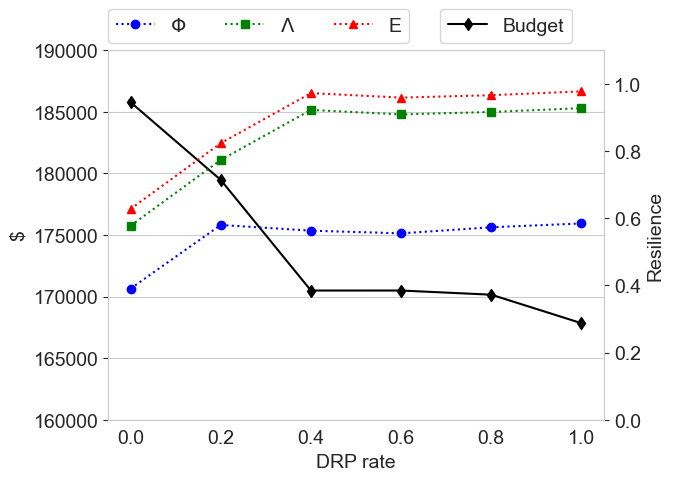

In [89]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

table = pd.read_csv(f'Results/(MG{mg_id})sensitivity_drp.csv')

x = table['drp']
y0 = table['Investment'] + table['Expansion']
y1 = table['Bill Saving']
y2 = table[['Phi', 'Lambda', 'E']]
label = {'Phi': r'$\Phi$', 'Lambda': r'$\Lambda$', 'E':'E'}

figure, ax1 = plt.subplots()
# Primary axis plot
ax1.plot(x, y0, label='Budget', color='black', marker='d', zorder=1)
ax1.set_xlabel('DRP rate')
ax1.set_ylabel('$')
ax1.legend(ncol=1, loc=[0.67, 1.02])
ax1.grid(axis='x', which='both')
ax1.set_ylim([160000, 190000])
# Secondary axis plot
ax2 = ax1.twinx()
markers = ['o', 's', '^']
colors = ['blue', 'green', 'red']
for col, marker, color in zip(y2.columns, markers, colors):
    ax2.plot(x, y2[col], label=label[col], marker=marker, color=color, linestyle=':', zorder=2)
ax2.set_ylim([0, 1.1])
ax2.legend(ncol=3, loc=[0, 1.02])
ax2.set_ylabel('Resilience')
ax2.grid(False)  # Turn off grid for secondary axis

plt.savefig(f'IMG/(MG{mg_id})sensitivity_drp.jpg', dpi=600, bbox_inches='tight')

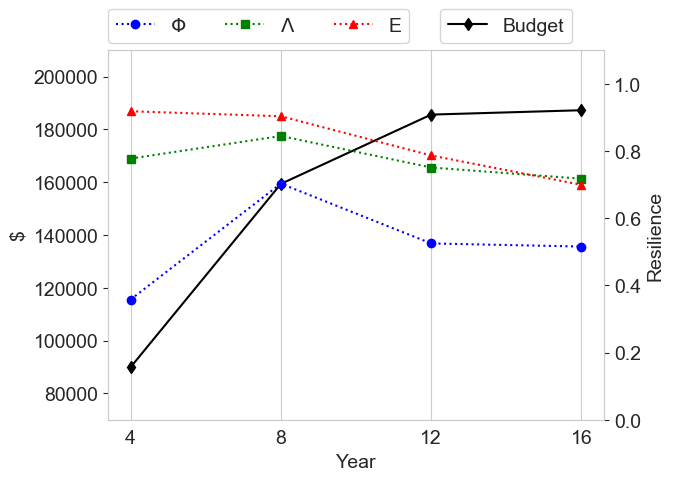

In [90]:
plt.rcParams.update({'font.size': 14})

table = pd.read_csv(f'Results/(MG{mg_id})sensitivity_year.csv')

x = table['year']
y0 = table['Investment'] + table['Expansion']
y2 = table[['Phi', 'Lambda', 'E']]
label = {'Phi': r'$\Phi$', 'Lambda': r'$\Lambda$', 'E':'E'}

figure, ax1 = plt.subplots()
# Primary axis plot
ax1.plot(x, y0, label='Budget', color='black', marker='d')
ax1.set_xlabel('Year')
ax1.set_xticks([4, 8, 12, 16, 20])
ax1.set_ylabel('$')
ax1.legend(ncol=1, loc=[0.67, 1.02])
ax1.grid(axis='y', which='both')
ax1.set_ylim([70000, 210000])
# Secondary axis plot
ax2 = ax1.twinx()
markers = ['o', 's', '^']
colors = ['blue', 'green', 'red']
for col, marker, color in zip(y2.columns, markers, colors):
    ax2.plot(x, y2[col], label=label[col], marker=marker, color=color, linestyle=':')
ax2.set_ylim([0, 1.1])
ax2.legend(ncol=3, loc=[0, 1.02])
ax2.set_ylabel('Resilience')
ax2.grid(False)  # Turn off grid for secondary axis

plt.savefig(f'IMG/(MG{mg_id})sensitivity_year.jpg', dpi=600)

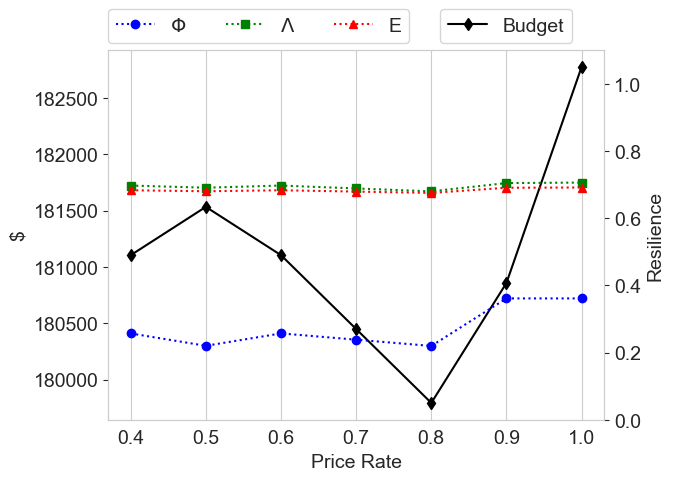

In [91]:
plt.rcParams.update({'font.size': 14})

table = pd.read_csv(f'Results/(MG{mg_id})sensitivity_price.csv')

x = table['price']
y0 = table['Investment'] + table['Expansion']
y1 = table['Expansion']
y2 = table[['Phi', 'Lambda', 'E']]
label = {'Phi': r'$\Phi$', 'Lambda': r'$\Lambda$', 'E':'E'}

figure, ax1 = plt.subplots()
# Primary axis plot
ax1.plot(x, y0, label='Budget', color='black', marker='d')
ax1.set_xlabel('Price Rate')
ax1.set_ylabel('$')
ax1.legend(ncol=1, loc=[0.67, 1.02])
ax1.grid(axis='y', which='both')
#ax1.set_ylim([170000, 190000])
# Secondary axis plot
ax2 = ax1.twinx()
markers = ['o', 's', '^']
colors = ['blue', 'green', 'red']
for col, marker, color in zip(y2.columns, markers, colors):
    ax2.plot(x, y2[col], label=label[col], marker=marker, color=color, linestyle=':')
ax2.set_ylim([0, 1.1])
ax2.legend(ncol=3, loc=[0, 1.02])
ax2.set_ylabel('Resilience')
ax2.grid(False)  # Turn off grid for secondary axis

plt.savefig(f'IMG/(MG{mg_id})sensitivity_price.jpg', dpi=600)

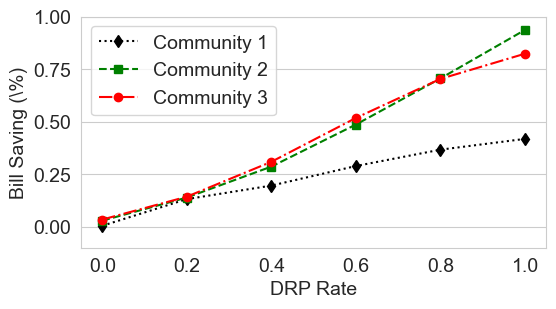

In [58]:
plt.rcParams.update({'font.size': 14})

df0= pd.read_csv(f'Results/(MG0)sensitivity_drp.csv')
df1= pd.read_csv(f'Results/(MG1)sensitivity_drp.csv')
df2= pd.read_csv(f'Results/(MG2)sensitivity_drp.csv')

x = df0['drp']
y0 = df0['Bill Saving']
y1 = df1['Bill Saving']
y2 = df2['Bill Saving']

figure = plt.figure(figsize=(6, 3))
plt.plot(x, y0, ':', label='Community 1', color='black', marker='d')
plt.plot(x, y1, '--', label='Community 2', color='green', marker='s')
plt.plot(x, y2, '-.', label='Community 3', color='red', marker='o')
plt.xlabel('DRP Rate')
plt.ylabel('Bill Saving (\%)')
plt.ylim([-.1, 1])
plt.legend()
plt.grid(axis='x')

plt.savefig(f'IMG/sensitivity_drp_bill.jpg', dpi=600)

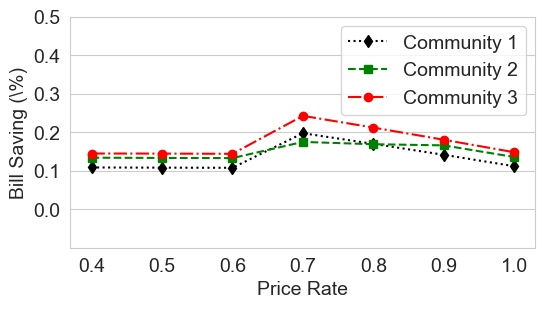

In [65]:
plt.rcParams.update({'font.size': 14})

df0= pd.read_csv(f'Results/(MG0)sensitivity_price.csv')
df1= pd.read_csv(f'Results/(MG1)sensitivity_price.csv')
df2= pd.read_csv(f'Results/(MG2)sensitivity_price.csv')

x = df0['price']
y0 = df0['Bill Saving']
y1 = df1['Bill Saving']
y2 = df2['Bill Saving']

figure = plt.figure(figsize=(6, 3))
plt.plot(x, y0, ':', label='Community 1', color='black', marker='d')
plt.plot(x, y1, '--', label='Community 2', color='green', marker='s')
plt.plot(x, y2, '-.', label='Community 3', color='red', marker='o')
plt.xlabel('Price Rate')
plt.ylabel('Bill Saving (\%)')
plt.ylim([-.1, 0.5])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4,0.5])
plt.legend()
plt.grid(axis='x')

plt.savefig(f'IMG/sensitivity_price_bill.jpg', dpi=600)

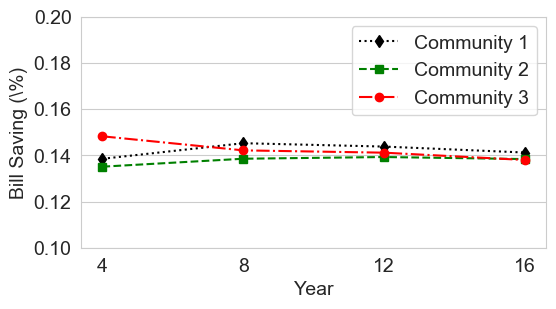

In [62]:
plt.rcParams.update({'font.size': 14})

df0= pd.read_csv(f'Results/(MG0)sensitivity_year.csv')
df1= pd.read_csv(f'Results/(MG1)sensitivity_year.csv')
df2= pd.read_csv(f'Results/(MG2)sensitivity_year.csv')

x = df0['year']
y0 = df0['Bill Saving']
y1 = df1['Bill Saving']
y2 = df2['Bill Saving']

figure = plt.figure(figsize=(6, 3))
plt.plot(x, y0, ':', label='Community 1', color='black', marker='d')
plt.plot(x, y1, '--', label='Community 2', color='green', marker='s')
plt.plot(x, y2, '-.', label='Community 3', color='red', marker='o')
plt.xlabel('Year')
plt.xticks([4, 8, 12, 16])
plt.ylabel('Bill Saving (\%)')
plt.ylim([0.1, 0.2])
plt.legend()
plt.grid(axis='x')

plt.savefig(f'IMG/sensitivity_year_bill.jpg', dpi=600)